In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pickle

from glob import iglob
import datetime

In [2]:
import importlib
import src.pipeline as pipeline

In [6]:
importlib.reload(pipeline)

<module 'src.pipeline' from '/Users/vinsonmccready/galvanize/loan-default-predictor/src/pipeline.py'>

In [3]:
data = pipeline.get_all_data('data/raw/')

In [4]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,year,date,days_earlist_cr
0,145217616,NaN,10000,10000,10000.0,36 months,10.33%,324.23,B,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,2018-12-01,8370
1,145640422,NaN,2500,2500,2500.0,36 months,13.56%,84.92,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,2018-12-01,6453
2,145630143,NaN,12000,12000,12000.0,60 months,13.56%,276.49,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,2018-12-01,4870
3,145127870,NaN,15000,15000,14975.0,60 months,14.47%,352.69,C,C2,...,0.0,16.0,48.8,15.0,0.0,0.0,NaN,18,2018-12-01,7001
4,145558466,NaN,16000,16000,16000.0,60 months,17.97%,406.04,D,D1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,2018-12-01,4809


In [5]:
with open('data/X_drop.pickle', 'rb') as f:
    cols = pickle.load(f)

In [6]:
drop = cols

## Data
The data includes loans that are not complete. I will be looking primarily at loans that are either fully paid off or charged off. 

In [7]:
data['loan_status'].value_counts()

Current               2086919
Fully Paid             552459
Charged Off            131231
Late (31-120 days)      32304
In Grace Period         22089
Issued                  21294
Late (16-30 days)        8147
Default                    29
Name: loan_status, dtype: int64

Additional analysis may be done on joint applications, but for the purposes of this predictor I will only be using individual applicants. 

In [8]:
data['application_type'].value_counts()

INDIVIDUAL    1359464
Individual    1284175
Joint App      194206
JOINT           13707
DIRECT_PAY       2920
Name: application_type, dtype: int64

In [9]:
# Only use individual loan types
data = pipeline.individual_data(data)
data['application_type'].unique()

array(['Individual', 'INDIVIDUAL'], dtype=object)

In [10]:
data.shape[0]

2643639

### Missing Data
There is a significant amount of missing data in some columns. These however are still very useful columns and the null value generally indicates a 0 value. 

In [11]:
# Columns with missing data

data[data.columns[data.isnull().sum()/data.shape[0] > .2]].isnull().sum()/data.shape[0]

member_id                              1.000000
desc                                   0.963374
mths_since_last_delinq                 0.519161
mths_since_last_record                 0.850447
next_pymnt_d                           0.254702
mths_since_last_major_derog            0.744397
annual_inc_joint                       1.000000
dti_joint                              1.000000
verification_status_joint              1.000000
open_acc_6m                            0.311407
open_il_12m                            0.311406
open_il_24m                            0.311406
mths_since_rcnt_il                     0.331586
total_bal_il                           0.311406
il_util                                0.407763
open_rv_12m                            0.311406
open_rv_24m                            0.311406
max_bal_bc                             0.311406
all_util                               0.311497
inq_fi                                 0.311406
total_cu_tl                            0

There are some columns that have 100% missing data; this will be handled before creating my training variable X. 

<AxesSubplot:>

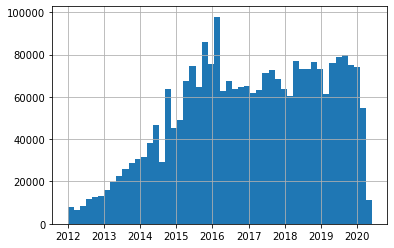

In [12]:
# Taking a look at values per year

data['date'].hist(bins=50)

In [13]:
# Average number of columns with missing values per row for each year

for y in np.sort(data['year'].unique()):
    print(y, data[data['year']==y].isna().sum().sum()/data[data['year']==y].shape[0])

12 48.52524968613562
13 34.57020042428828
14 34.36992899855281
15 33.481347364616816
16 21.1244878454973
17 21.127428152609642
18 21.35766216155981
19 21.398317451564527
20 21.34044473778718


### Preprocessing

In [14]:
# Clean data (change from string to numeric)

data = pipeline.clean_data(data)

In [15]:
# Looking at years of data available

np.sort(data['year'].unique())

array([12, 13, 14, 15, 16, 17, 18, 19, 20])

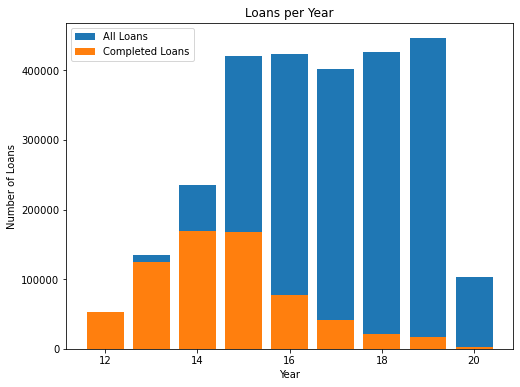

In [16]:
# Look at volumes of loans per year
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(data['year'].value_counts().index,data['year'].value_counts(), label='All Loans')
ax.bar(pipeline.completed_filter(data)['year'].value_counts().index,
       pipeline.completed_filter(data)['year'].value_counts(), 
       label='Completed Loans')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Loans')
ax.set_title('Loans per Year')
plt.legend()
plt.savefig('img/loans_per_year.jpg')

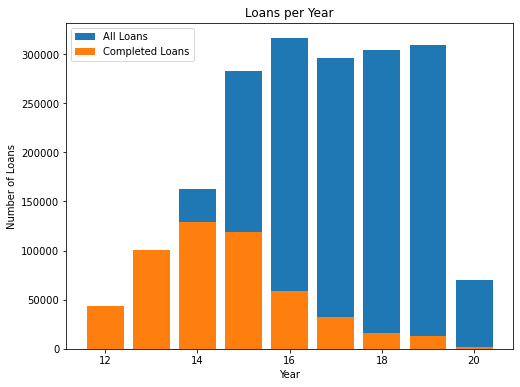

In [17]:
# Look at volumes of loans per year
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(pipeline.term_filter(36,data)['year'].value_counts().index,pipeline.term_filter(36,data)['year'].value_counts(), label='All Loans')
ax.bar(pipeline.completed_filter(pipeline.term_filter(36,data))['year'].value_counts().index,
       pipeline.completed_filter(pipeline.term_filter(36,data))['year'].value_counts(), 
       label='Completed Loans')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Loans')
ax.set_title('Loans per Year')
plt.legend()
# plt.savefig('img/loans_per_year.jpg')

From 2015 on we see fewer and fewer completed loans. This is because the terms can be up to 5 years. We will only be using data from early 2015 which have terms that should be complete from when this data was downloaded. 

In [18]:
# Looking at ratio of charged off loans per year. 
# Recent years are lower because they are not complete yet

data[data['loan_status']=='Charged Off'].groupby('year')['year'].count()/data.groupby('year')['year'].count()

year
12    0.160774
13    0.148375
14    0.147541
15    0.104954
16    0.037019
17    0.012335
18    0.002672
19    0.001715
20    0.000155
Name: year, dtype: float64

In [19]:
# with open('data/X_drop.pickle', 'wb') as f:
#     pickle.dump(drop, f)

In [20]:


(data['loan_status']=='Charged Off').sum()/data.shape[0]

0.04917728933489028

In [21]:
def ratio_defaulted(column, data):
    ratios = (data[data['loan_status']=='Charged Off'][column].value_counts(dropna=False)/
              data[column].value_counts(dropna=False)).sort_index().values
    vals = (data[data['loan_status']=='Charged Off'][column].value_counts(dropna=False)/
            data[column].value_counts(dropna=False)).sort_index().index.values
    if type(vals[-1])==float:
        vals[-1]='NA'
    return vals, ratios

In [22]:
def plot_defaultrate_categorical(column, ax):
    ax.bar(ratio_defaulted(column, data)[0],
           ratio_defaulted(column, data)[1])

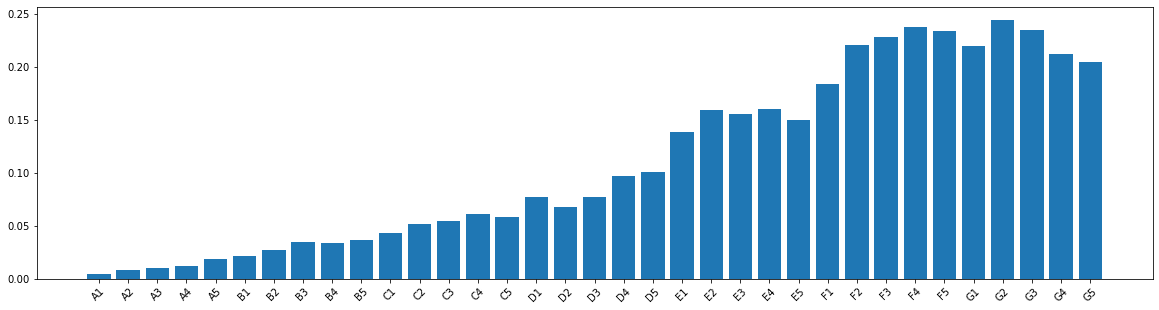

In [23]:
fig, ax = plt.subplots(figsize=(20,5))

plot_defaultrate_categorical('sub_grade', ax=ax)
plt.xticks(rotation=45)
plt.show()

In [24]:
# Missing values
pipeline.print_missing(data.drop(drop, axis=1)[data['year'] > 12])

'inq_last_6mths': number of missing values '1' ==> '0.000%'
'mths_since_last_delinq': number of missing values '1341074' ==> '51.773%'
'mths_since_last_record': number of missing values '2196381' ==> '84.793%'
'revol_util': number of missing values '2006' ==> '0.077%'
'mths_since_last_major_derog': number of missing values '1919932' ==> '74.121%'
'open_acc_6m': number of missing values '769880' ==> '29.722%'
'open_il_12m': number of missing values '769879' ==> '29.722%'
'open_il_24m': number of missing values '769879' ==> '29.722%'
'mths_since_rcnt_il': number of missing values '823228' ==> '31.782%'
'total_bal_il': number of missing values '769879' ==> '29.722%'
'il_util': number of missing values '1024610' ==> '39.556%'
'open_rv_12m': number of missing values '769879' ==> '29.722%'
'open_rv_24m': number of missing values '769879' ==> '29.722%'
'max_bal_bc': number of missing values '769879' ==> '29.722%'
'all_util': number of missing values '770119' ==> '29.731%'
'inq_fi': number of 

<AxesSubplot:>

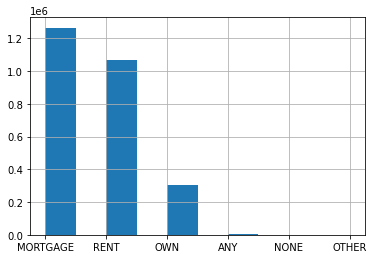

In [25]:
data['home_ownership'].hist()

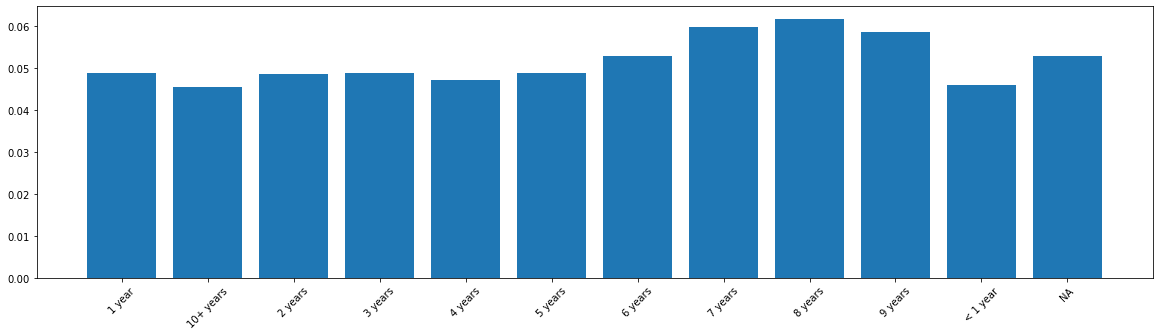

In [26]:
fig, ax = plt.subplots(figsize=(20,5))

plot_defaultrate_categorical('emp_length', ax=ax)
plt.xticks(rotation=45)
plt.show()

In [27]:
drop

['member_id',
 'desc',
 'next_pymnt_d',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'funded_amnt_inv',
 'grade',
 'emp_title',
 'emp_length',
 'pymnt_plan',
 'url',
 'title',
 'zip_code',
 'earliest_cr_line',
 'fico_range_high',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_credit_pull_d',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'delinq_amnt',
 'application_type',
 'issue_d',
 'id',
 'loan_status',
 'year',
 'dat

In [28]:
drop.append('addr_state')

### Create X and y variables

In [186]:
import src.model as model

In [339]:
importlib.reload(pipeline)

<module 'src.pipeline' from '/Users/vinsonmccready/galvanize/loan-default-predictor/src/pipeline.py'>

In [219]:
# Create training set using earlier data. Only looking at completed loans. 
# Only looking at 36 month loans. 

training = pipeline.completed_filter(
    pipeline.date_filter(datetime.date(2012, 1,1), datetime.date(2014, 6,1), 
    pipeline.create_dummies(data)))

In [220]:
X_train = pipeline.create_X(training, drop)
y_train = pipeline.create_y(training)

In [221]:
X_train.shape

(252164, 125)

In [198]:
pipeline.date_filter(datetime.date(2014, 6,1), datetime.date(2015, 1,1), 
    pipeline.term_filter(36,data))['loan_status'].value_counts()

Current               144387
Fully Paid             21127
Charged Off             3108
Late (31-120 days)      2979
In Grace Period         2044
Late (16-30 days)        716
Default                    2
Name: loan_status, dtype: int64

In [222]:
# Holdout data will be later data that has completed 36 month loans. 

test = pipeline.completed_filter(
    pipeline.date_filter(datetime.date(2014, 6,1), datetime.date(2015, 1,1), 
    pipeline.create_dummies(data)))

In [223]:
X_test = pipeline.create_X(test, drop)
y_test = pipeline.create_y(test)

In [209]:
# validation[~validation['loan_status'].str.lower().isin(['fully paid', 'charged off'])]['loan_status'].unique()

In [210]:
# X_val = pipeline.create_X(validation[~validation['loan_status'].str.lower().isin(['fully paid', 'charged off'])], drop)
# y_val = pipeline.create_y(validation[~validation['loan_status'].str.lower().isin(['fully paid', 'charged off'])])

In [224]:
for c in X_train.columns:
    if c not in X_test.columns:
        print(c)

In [225]:
print(X_train.shape)
print(X_test.shape)

(252164, 125)
(93986, 125)


In [226]:
# Make sure validation set is ok ratio of data. 
X_test.shape[0]/(X_test.shape[0] + X_train.shape[0])

0.2715181279791998

In [231]:
y_test.sum()/y_test.shape[0]

0.23202391845594025

### Models

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import recall_score, precision_score, roc_auc_score

In [44]:
# X_train, X_test, y_train, y_test = train_test_split(X,y)

In [227]:
rf_model = RandomForestClassifier(n_jobs=-1, random_state=1)
rf_model.fit(X_train, y_train)
recall = recall_score(y_test, rf_model.predict(X_test))
precision = precision_score(y_test, rf_model.predict(X_test))
print(f'Recall: {recall}\nPrecision: {precision}')

Recall: 0.035172192415279496
Precision: 0.6126198083067093


In [228]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
recall = recall_score(y_test, gb_model.predict(X_test))
precision = precision_score(y_test, gb_model.predict(X_test))
print(f'Recall: {recall}\nPrecision: {precision}')

Recall: 0.04888338606869354
Precision: 0.6263219741480611


In [229]:
roc_auc_score(y_test, rf_model.predict(X_test))

0.5142263932469449

In [230]:
roc_auc_score(y_test, gb_model.predict(X_test))

0.5200359794611468

In [393]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [399]:
gradient_boosting_grid = {'learning_rate': [ 0.1],
                          'max_depth': [2, 4, 6],
                          'min_samples_leaf': [1, 2, 5],
                          'max_features': [1.0, 0.3],
                          'n_estimators': [100],
                          'random_state': [1]}

model_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                                gradient_boosting_grid,
                                n_jobs=-1,
                                verbose=True,
                                scoring=roc_auc_score)
model_gridsearch.fit(X_train, y_train)
best_params = model_gridsearch.best_params_ 
model_best = model_gridsearch.best_estimator_
print("\nResult of gridsearch:")
print("{0:<20s} | {1:<8s} | {2}".format("Parameter", "Optimal", "Gridsearch values"))
print("-" * 55)
for param, vals in parameter_grid.items():
    print("{0:<20s} | {1:<8s} | {2}".format(str(param), 
                                            str(best_params[param]),
                                            str(vals)))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


KeyboardInterrupt: 

In [162]:
y_test.sum()/y_test.shape[0]

0.18617013592962284

In [60]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
    
def plot_roc(ax, df):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend()
    
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(left=0,right=1)
    ax.set_ylim(bottom=0,top=1)

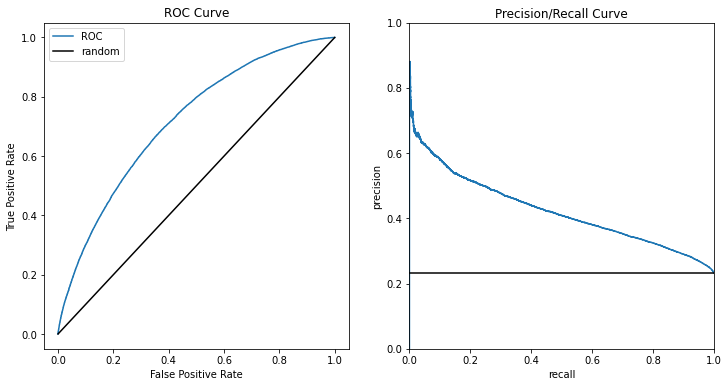

In [233]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
df = calculate_threshold_values(gb_model.predict_proba(X_test)[:,1], y_test)
plot_roc(ax0, df)
plot_precision_recall(ax1, df)

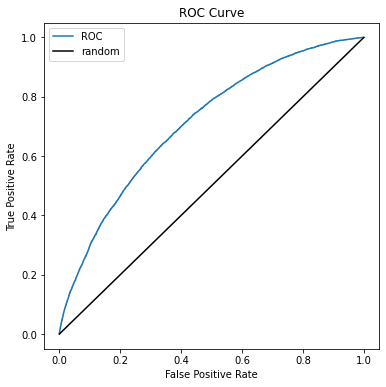

In [407]:
fig, ax = plt.subplots(figsize=(6,6))
df = calculate_threshold_values(gb_model.predict_proba(X_test)[:,1], y_test)
plot_roc(ax, df)
plt.savefig('img/roc_plot.jpg')

In [234]:
probabilities = gb_model.predict_proba(X_test)

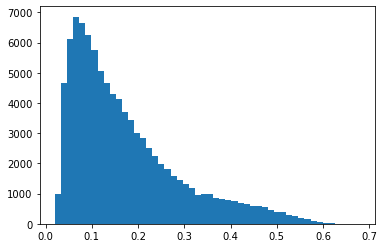

In [235]:
fig, ax = plt.subplots()
ax.hist(probabilities[:,1], bins=50);

In [236]:
(probabilities > .5).sum()

93986

In [237]:
y_test.sum()

21807

In [238]:
threshold = np.linspace(0,1,100)
yhat = gb_model.predict_proba(X_test)[:,1]

recall = []
precision = []
for t in threshold:
    c = pd.crosstab(pd.Categorical(y_test, categories=[0,1]), 
                    pd.Categorical(yhat>t, categories=[0,1]), 
                    rownames=['actual'], 
                    colnames=['predicted'],
                    dropna=False)
    r = c[1][1]/(c[1][1]+c[0][1])
    p = c[1][1]/(c[1][1]+c[1][0])
    recall.append(r)
    precision.append(p)

<ipython-input-238-699a34eff20f>:13: RuntimeWarning: invalid value encountered in long_scalars
  p = c[1][1]/(c[1][1]+c[1][0])


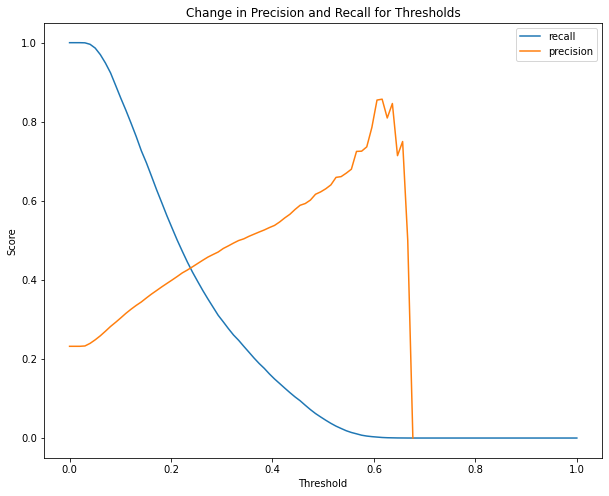

<Figure size 432x288 with 0 Axes>

In [239]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(threshold, recall, label='recall')
ax.plot(threshold, precision, label='precision')
# ax.vlines([.08, .85], 0,1, linestyles='--', colors='green')
ax.legend()
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Change in Precision and Recall for Thresholds')
plt.show()
plt.savefig('img/recall_precision.jpg')

In [240]:
y_prob = gb_model.predict_proba(X_test)[:,1]

In [241]:
# make predictions based on probabilities and threshold
def predict(model, X, threshold=0.5):
    '''Return prediction of the fitted binary-classifier model model on X using
    the specifed `threshold`. NB: class 1 is the positive class'''
    return np.where(model.predict_proba(X)[:,1] > threshold, 1, 0)

# create confusion matrix with a given model and Xtest
def confusion_matrix(model, X, y,  threshold=0.5):
    cf = pd.crosstab(y, predict(model, X, threshold), dropna=False)
    cf = cf.add(pd.DataFrame([[0,0],[0,0]], columns=[0, 1], index=[0, 1]), fill_value=0)
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

# calculate the payout for a given probability threshold
def calculate_payout(cb_matrix, model, X, y, threshold):
    return (confusion_matrix(model, X, y, threshold) * cb_matrix).values.sum()

In [242]:
gb_model.classes_

array([0, 1])

In [243]:
cf = confusion_matrix(gb_model, X_test, y_test)

In [244]:
cf

predicted,0,1
actual,,
0,71543,636
1,20741,1066


In [245]:
# Cost benefit
def get_profits(model, X, y):
    cb_matrix = pd.DataFrame([[0, -1991], [0, 8538]], columns=[0, 1], index=[0,1])
    cb_matrix.index.name = 'actual'
    cb_matrix.columns.name = 'predicted'
    # calculate the payout with a the cost benefit matrix, 
    # given threshhold, model, and X
    thresholds = np.arange(0.0, 1.0, 0.01)
    profits = []
    for threshold in thresholds:
        profits.append(calculate_payout(cb_matrix, model, X, y, threshold))
    return profits
    
    
def profit_curve(profits, ax):
    thresholds = np.arange(0.0, 1.0, 0.01)
    ax.plot(thresholds, profits)
    ax.set_xlabel('Thresholds')
    ax.set_ylabel('Profits')
    ax.set_title('Profit Curve')
    print(profits)

In [246]:
profits = get_profits(gb_model, X_test, y_test)

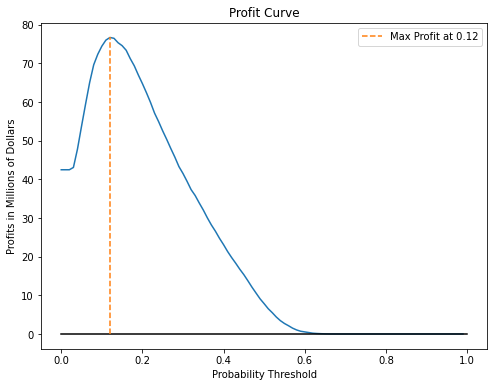

In [247]:
fig, ax = plt.subplots(figsize=(8, 6))
thresholds = np.arange(0.0, 1.0, 0.01)
ax.plot(thresholds, np.array(profits)/1000000)
ax.plot([0,1], [0,0], color='black')
ax.plot([threshold[np.argmax(profits)],threshold[np.argmax(profits)]], 
        [0,np.max(profits)/1000000], linestyle='--', label=f'Max Profit at {threshold[np.argmax(profits)]:.2f}')
ax.set_xlabel('Probability Threshold')
ax.set_ylabel('Profits in Millions of Dollars')
ax.set_title('Profit Curve')
# ax.set_ylim(-1, 3)
ax.ticklabel_format(style='plain')
plt.legend()
# ax.set_ylim(-250000, 200000)
plt.savefig('img/profit_curve.jpg')

In [151]:
np.argmax(profits)

15

In [135]:
profits[35]

3152928

In [136]:
threshold[35]

0.3535353535353536

In [137]:
.26 * 8538/1991

1.1149573078854846

In [138]:
y_test.sum()/y_test.shape[0]

0.18617013592962284

In [139]:
def get_yhat(probs, threshold):
    return probs > threshold

In [140]:
def get_cf_arrays(y_true, y_hat):
    true_positive = (y_true == 1) & (y_hat==1)
    true_negative = (y_true == 0) & (y_hat==0)
    false_positive = (y_true == 0) & (y_hat==1)
    false_negative = (y_true == 1) & (y_hat==0)
    return true_positive, true_negative, false_positive, false_negative

In [141]:
tp, tn, fp, fn = get_cf_arrays(y_test, get_yhat(probabilities[:,1], .65))

In [142]:
tp.sum() + tn.sum() + fp.sum() + fn.sum()

69227

In [143]:
y_test.shape[0]

69227

In [144]:
payment = [
    'loan_amnt', 
    'funded_amnt',
    'out_prncp',
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee']

In [145]:
data.loc[y_test.index[fp]]['total_rec_int'].sum()

0.0

In [99]:
validation = pipeline.date_filter(datetime.date(2016, 1,1), datetime.date(2016, 4,1), 
    pipeline.term_filter(36, ))

In [103]:
X_val = pipeline.create_X(pipeline.date_filter(datetime.date(2016, 1,1), datetime.date(2017, 4,1), 
    pipeline.term_filter(36, 
    pipeline.create_dummies(data))), drop)

In [112]:
y_val = pipeline.create_y(pipeline.date_filter(datetime.date(2016, 1,1), datetime.date(2017, 4,1), 
    pipeline.term_filter(36, validation)))

In [129]:
validation['loan_status'].value_counts()

Current               311717
Fully Paid             51602
Charged Off            10637
Late (31-120 days)      6346
In Grace Period         4191
Late (16-30 days)       1463
Default                    5
Name: loan_status, dtype: int64

In [101]:
validation['potential_interest'] = validation.apply(lambda row: interest_calculator(row['funded_amnt'], row['int_rate'], row['installment']), axis=1)

In [116]:
val_prob = gb_model.predict_proba(X_val)

In [119]:
def savings_potential(tp, fp, interest=False):
    # Principal remaining
    funded = validation.loc[y_val.index[tp]]['funded_amnt'].sum()
    princ_rec = validation.loc[y_val.index[tp]]['total_rec_prncp'].sum()
    int_rec = validation.loc[y_val.index[tp]]['total_rec_int'].sum()
    missed_int = validation.loc[y_val.index[fp]]['total_rec_int'].sum()
    recovered = validation.loc[y_val.index[tp]]['recoveries'].sum()
    saved = funded - princ_rec - missed_int - int_rec - recovered
    if interest:
        saved -= int_rec
    return saved
    

In [120]:
savings = []
for t in threshold:
    tp, tn, fp, fn = get_cf_arrays(y_val, get_yhat(val_prob[:,1], t))
    savings.append(savings_potential(tp, fp))

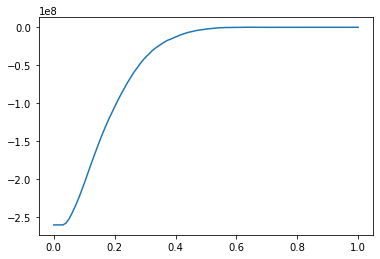

In [121]:
fig, ax = plt.subplots()

ax.plot(threshold, savings)

In [248]:
def potential_principal_saved(tp, fp, interest=False):
    # Principal remaining
    funded = data.loc[y_test.index[tp]]['funded_amnt'].sum()
    princ_rec = data.loc[y_test.index[tp]]['total_rec_prncp'].sum()
    int_rec = data.loc[y_test.index[tp]]['total_rec_int'].sum()
    missed_int = data.loc[y_test.index[fp]]['total_rec_int'].sum()
    recovered = data.loc[y_test.index[tp]]['recoveries'].sum()
    saved = funded - princ_rec - missed_int - int_rec - recovered
    if interest:
        saved -= int_rec
    return saved

In [249]:
probabilities = gb_model.predict_proba(X_test)

In [250]:
savings = []
for t in threshold:
    tp, tn, fp, fn = get_cf_arrays(y_test, get_yhat(probabilities[:,1], t))
    savings.append(potential_principal_saved(tp, fp))

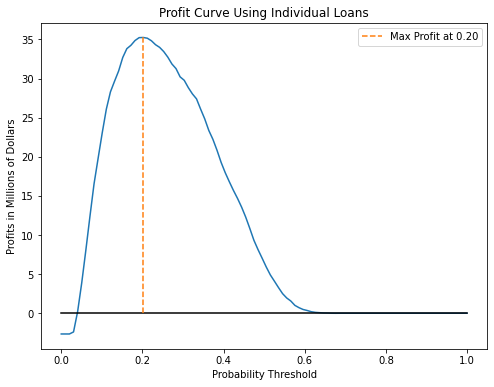

In [252]:
fig, ax = plt.subplots(figsize=(8,6))
ax.ticklabel_format(style='plain')
ax.plot(threshold, np.array(savings)/1000000)
ax.plot([0,1], [0,0], color='black')
ax.plot([threshold[np.argmax(savings)],threshold[np.argmax(savings)]], 
        [0,np.max(savings)/1000000], linestyle='--', label=f'Max Profit at {threshold[np.argmax(savings)]:.2f}')
ax.set_xlabel('Probability Threshold')
ax.set_ylabel('Profits in Millions of Dollars')
ax.set_title('Profit Curve Using Individual Loans')
plt.legend()
ax.ticklabel_format(style='plain')
plt.savefig('img/profit_curve_real.jpg')

In [379]:
savings = []
for t in threshold:
    tp, tn, fp, fn = get_cf_arrays(y_test, get_yhat(probabilities[:,1], t))
    savings.append(potential_principal_saved(tp, fp, True))


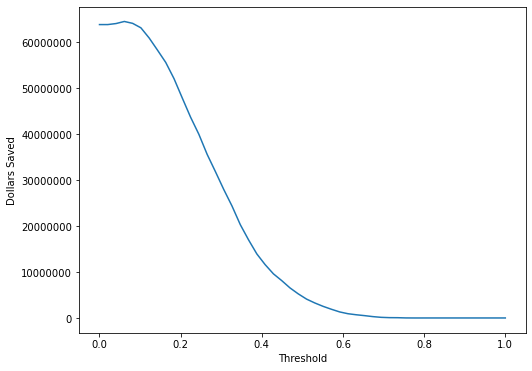

In [380]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(threshold, savings)
ax.set_xlabel('Threshold')
ax.set_ylabel('Dollars Saved')
ax.ticklabel_format(style='plain')

In [462]:
(probabilities[:,1]>0).sum()

62239

In [463]:
y_test.shape

(62239,)

### Find savings from future loans

In [106]:
threshold[np.argmax(savings)]

0.22448979591836732

In [71]:
tp, tn, fp, fn = get_cf_arrays(y_test, get_yhat(probabilities[:,1], .8))

In [72]:
funded = data.loc[y_test.index[tp]]['funded_amnt'].sum()
princ_rec = data.loc[y_test.index[tp]]['total_rec_prncp'].sum()
int_rec = data.loc[y_test.index[tp]]['total_rec_int'].sum()
missed_int = data.loc[y_test.index[fp]]['total_rec_int'].sum()
recovered = data.loc[y_test.index[tp]]['recoveries'].sum()
saved = funded - princ_rec - missed_int - int_rec - recovered
saved

59401792.78999999

In [73]:
current_loan_prob = rf_model.predict_proba(X_val)

In [1]:
#

In [94]:
def interest_calculator(funded, interest, payment):
    current_balance = funded
    r = interest/100
    interest_paid = 0
    while current_balance > 0:
        accrued = (current_balance * r)/12
        interest_paid += accrued
        current_balance -= (payment - accrued)
        if interest_paid > funded:
            return 0
    return round(interest_paid,2)
    

In [ ]:
validation = validation.copy()
validation['potential_interest'] = validation.apply(lambda row: interest_calculator(row['funded_amnt'], row['int_rate'], row['installment']), axis=1)

In [76]:
interest_calculator(data.loc[0, 'funded_amnt'], data.loc[0, 'int_rate'], data.loc[0, 'installment'])

1672.0

In [78]:
validation['potential_interest']

0           1672.00
1            556.71
2           4589.33
4           8361.80
5           3850.20
             ...   
2420059    29067.86
2420060     4782.94
2420062     1955.40
2420063    10565.62
2420064     7660.90
Name: potential_interest, Length: 1376521, dtype: float64

In [85]:
validation.loc[y_val.index[current_loan_prob[:,1] > .5]]['potential_interest'].sum()

127019778.61

In [87]:

potential_interest = []
for t in threshold:
    potential_interest.append(validation.loc[y_val.index[current_loan_prob[:,1] > t]]['potential_interest'].sum())

Text(0, 0.5, 'Dollars Saved')

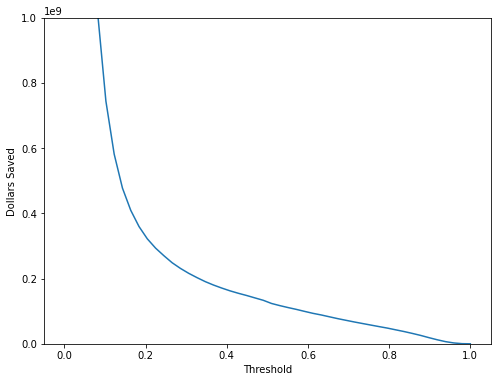

In [101]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(threshold, np.array(potential_interest))
ax.set_ylim(0,1000000000)
ax.set_xlabel('Threshold')
ax.set_ylabel('Dollars Saved')

In [89]:
net = np.array(savings)-np.array(potential_interest)

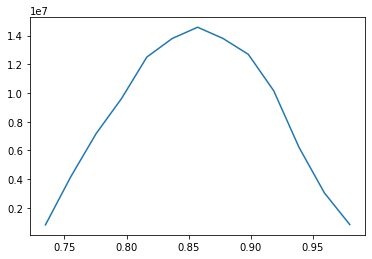

In [106]:
fig, ax = plt.subplots()

ax.plot(threshold[net>0],net[net > 0])

In [103]:
threshold[net > 0]

array([0.73469388, 0.75510204, 0.7755102 , 0.79591837, 0.81632653,
       0.83673469, 0.85714286, 0.87755102, 0.89795918, 0.91836735,
       0.93877551, 0.95918367, 0.97959184])

## Calculating how much is saved

In [544]:
loans2012_2017 = pipeline.completed_filter(
    pipeline.date_filter(datetime.date(2017, 1,1), datetime.date(2017, 1,1), 
    data))

In [545]:
funded = loans2012_2017['funded_amnt'].sum()
princ_rec = loans2012_2017['total_rec_prncp'].sum()
int_rec = loans2012_2017['total_rec_int'].sum()
recovered = loans2012_2017['recoveries'].sum()


In [554]:
date_range = []
for y in range(2012, 2018):
    for m in range(1,13):
        date_range.append(datetime.date(y,m,1))

In [567]:
completed = pipeline.term_filter(36,data)

In [568]:
profits = []
completed_loans = []
for month in date_range:
    month_data = completed[completed['date']==month]
    funded = month_data['funded_amnt'].sum()
    princ_rec = month_data['total_rec_prncp'].sum()
    int_rec = month_data['total_rec_int'].sum()
    recovered = month_data['recoveries'].sum()
    profits.append(princ_rec+int_rec+recovered-funded)
    completed_loans.append(month_data.shape[0])

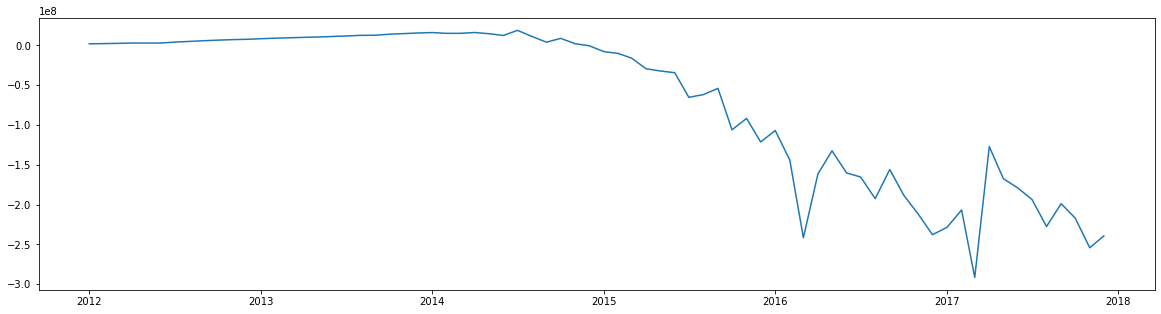

In [569]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(date_range, profits)

In [536]:
data[data['loan_status']=='Fully Paid']['total_rec_int'].mean()

1911.0410812153877

In [538]:
data[data['loan_status']=='Charged Off']['total_rec_int'].mean() + data[data['loan_status']=='Charged Off']['total_rec_prncp'].mean() + data[data['loan_status']=='Charged Off']['recoveries'].mean() - data[data['loan_status']=='Charged Off']['funded_amnt'].mean()

-8538.164347304839

In [546]:
princ_rec + int_rec + recovered - funded

-351745455.95999956

In [492]:
recovered

7926490.57

In [475]:
int_rec/funded

0.06195930863514992

In [445]:
b = funded - princ_rec - int_rec - recovered

In [446]:
a+b

-157428232.6400001

In [481]:
data[data['loan_status']=='Charged Off']['funded_amnt'].describe()

count    130007.000000
mean      15421.807095
std        8617.264813
min        1000.000000
25%        9000.000000
50%       14025.000000
75%       20000.000000
max       40000.000000
Name: funded_amnt, dtype: float64

In [330]:
data.shape

(2643639, 129)

In [451]:
loans2012_2017['loan_status'].value_counts()[1]/(loans2012_2017['loan_status'].value_counts()[0]+loans2012_2017['loan_status'].value_counts()[1])

0.1661021801365338

In [551]:
data[data['term']==36].groupby('year')['loan_status'].value_counts()

year  loan_status       
12    Fully Paid             37567
      Charged Off             5903
13    Fully Paid             88044
      Charged Off            12378
14    Fully Paid            108778
      Current                31114
      Charged Off            20709
      Late (31-120 days)      1045
      In Grace Period          726
      Late (16-30 days)        194
      Default                    4
15    Current               156183
      Fully Paid             92682
      Charged Off            25800
      Late (31-120 days)      4521
      In Grace Period         2900
      Late (16-30 days)        840
      Default                    8
16    Current               246925
      Fully Paid             47827
      Charged Off            10590
      Late (31-120 days)      5905
      In Grace Period         3654
      Late (16-30 days)       1301
      Default                    3
17    Current               257362
      Fully Paid             28769
      Late (31-120 days)      